In [1]:
import numpy as np
import numpy.random as random

import matplotlib.pyplot as plt
from typing import List
%matplotlib inline

# Part 2

In [2]:
distance_matrix: List[List[float]] = []

class City:

    def __init__(self, index: int, x: float, y: float):
        self.index = index
        self.x = x
        self.y = y

    def compute_distance(self, city: "City"):
        return np.sqrt((self.x - city.x)**2 + (self.y - city.y)**2)

    def __str__(self):
        return '%d %f %f' % (self.index, self.x, self.y)

    def __repr__(self):
        return self.__str__()

    def distance_to_city(self, city: "City"):
        """Distance to another city using pre-computed distance."""
        global distance_matrix
        if self.index != city.index:
            indices = [self.index, city.index]
            return distance_matrix[max(indices)][min(indices)]
        return 0

In [3]:
def compute_distance_pair(cities: List[City], out: List[List[float]]):
    for city_from in cities:
        out.append([0 for r in range(city_from.index)])
        for city_to in cities[:city_from.index]:
            out[city_from.index][city_to.index] = city_from.compute_distance(city_to)

In [4]:
def read_cities(filename: str):
    with open(filename, 'r') as f:
        rows = [line.split() for line in f]
        cities = [City(index, float(coord[0]), float(coord[1])) for index, coord in enumerate(rows)]
        return cities

In [5]:
def total_distance(cities: List[City]):
    distances = [cities[index].distance_to_city(cities[(index + 1) % len(cities)]) for index in range(len(cities))]
    return sum(distances)

In [6]:
cities = read_cities("lau15_xy.txt")

In [7]:
compute_distance_pair(cities, distance_matrix)

In [8]:
distance_matrix

[[],
 [28.8733000549963],
 [82.12952630201566, 54.773225415025095],
 [45.798532289995, 45.658960397684105, 68.27106573725065],
 [68.35015747765308, 42.02945446628839, 45.67884154332288, 82.28891089934294],
 [52.07763037224608,
  43.217096744631874,
  54.76484963158395,
  14.401837905281393,
  74.25389314675697],
 [72.07872877509762,
  43.205581569150674,
  22.75820510045028,
  72.08048339443044,
  22.92069009063996,
  61.10753794545287],
 [42.021184255086084,
  22.76963428980829,
  43.25551073609003,
  30.51648564989095,
  52.130339835646566,
  22.70224944471363,
  42.11940302766127],
 [51.01660496179669,
  22.831269461146494,
  40.721275063692445,
  62.13119423103745,
  20.358579404342038,
  54.93979813631372,
  22.763969281659143,
  32.38730180735808],
 [54.999851491069606,
  30.618415611452697,
  28.70629548548541,
  42.025427983543494,
  45.73414736190017,
  30.515913275043896,
  30.59175084149257,
  14.549321997261593,
  28.962860693289603],
 [28.729621053402905,
  40.635150893428

In [9]:
def plot_cities(cities: List[City], figure_id: int):
    fig_map = plt.figure(figure_id)
    ax_map = fig_map.add_subplot(111)

    cities_x = [city.x for city in cities + [cities[0]]]
    cities_y = [city.y for city in cities + [cities[0]]]
    ax_map.plot(cities_x, cities_y, 'go-')
    ax_map.grid()

    return fig_map, ax_map

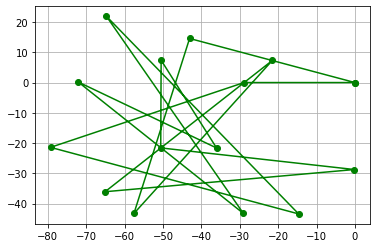

In [10]:
fig_map, ax_map = plot_cities(cities, 1)

In [11]:
total_distance(cities)

818.0261064149839

In [12]:
def compute_path_indeces(index: int, num_of_cities: int):
    index_previous = (index - 1) % num_of_cities
    index_next = (index + 1) % num_of_cities
    return (index_previous, index_next)

In [13]:
def distance_swap(cities: List[City], index_a: int, index_B: int):
    """
    Compute the distance inferred by the two given indices.
    Used to optimize computation of total distances
    """

    index_A = min(index_a, index_B)
    index_B = max(index_a, index_B)

    (index_a_previous, index_a_next) = compute_path_indeces(index_A, len(cities))
    (index_b_previous, index_b_next) = compute_path_indeces(index_B, len(cities))

    distances: List[float] = []

    distances.append(cities[index_a_previous].distance_to_city(cities[index_A]))
    distances.append(cities[index_B].distance_to_city(cities[index_b_next]))

    # two cases of swaping indeces
    if index_A == index_b_previous:
        # --a_previous--a--b--b_next-- -> --a_previous--b--a--b_next-- 
        distances.append(cities[index_A].distance_to_city(cities[index_B]))
    else:
        #--a_previous--a--a_next ... b_previous-b--b_next -> --a_previous--b--a_next ... b_previous-a--b_next 
        distances.append(cities[index_A].distance_to_city(cities[index_a_next]))
        distances.append(cities[index_b_previous].distance_to_city(cities[index_B]))
        
    return sum(distances)

In [14]:
def annealing(cities: List[City], temperature: float = 100, temperature_end: float = 1, cooling_factor: float=.99):
    cities_best = cities[:]
    distance_best = total_distance(cities_best)
    print(distance_best)

    cities_new = cities_best[:]
    cities_current = cities_best[:]

    distance_new = distance_best
    distance_current = distance_best

    step = 0
    while temperature > temperature_end:
        #choose indexes to swap random
        index_0: int = random.randint(low=1, high=len(cities))
        index_1: int = random.randint(low=1, high=len(cities))

        swap_before = distance_swap(cities_new, index_0, index_1)
        cities_new[index_0], cities_new[index_1] = cities_new[index_1], cities_new[index_0]
        swap_after = distance_swap(cities_new, index_0, index_1)
        
        # distance_new = distance_new - swap_before + swap_after
        distance_new = total_distance(cities_new)
        # print(distance_new)
        diff = distance_new - distance_current

        if diff < 0 or  np.exp( -diff / temperature ) > random.random():
            cities_current = cities_new[:]
            distance_current = distance_new
        else:
            distance_new = distance_current
            cities_new = cities_current[:]

        if distance_current < distance_best:
            cities_best = cities_current[:]
            distance_best = distance_current

        temperature = temperature * cooling_factor
        step = step + 1
    
    return cities_best, distance_best, step


In [15]:
cities_best, distance_best, steps = annealing(cities, temperature=1e3, cooling_factor=0.999)

818.0261064149839


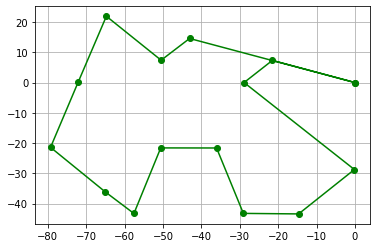

In [16]:
fig_map, ax_map = plot_cities(cities_best, 1)

In [17]:
total_distance(cities_best)

321.41747289475757